In [1]:
import torch
import numpy as np
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler


In [2]:
batch_size = 32
num_workers= 0
valid_size = 0.2

In [3]:
transform= transforms.ToTensor()

In [4]:
train_data = datasets.MNIST(root='data', train= True, download= True, transform= transform)
test_data = datasets.MNIST(root='data', train= False, download= True, transform= transform)

In [5]:
num_train=len(train_data)
indices=list(range(num_train))
np.random.shuffle(indices)
split=int(np.floor(valid_size*num_train))

train_idx,valid_idx= indices[split:],indices[:split]

In [6]:
train_sampler=SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

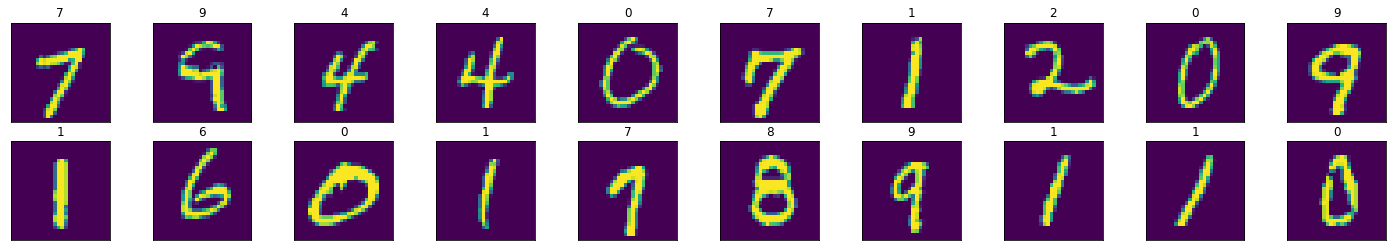

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig= plt.figure(figsize=(25,4))


for idx in np.arange(20):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(images[idx]))
    ax.set_title(str(labels[idx].item()))

In [9]:
import torch.nn as nn


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        
        hidden_1=512
        hidden_2=512
        
        
        self.fc1= nn.Linear(784,hidden_1)
        self.fc2= nn.Linear(hidden_1,hidden_2)
        self.fc3= nn.Linear(hidden_2, 10)
        
        self.dropout= nn.Dropout(0.2)
        
        
        
    def forward(self, x):
        x=x.view(-1,784)
        
        x=F.relu(self.fc1(x))
        x= self.dropout(x)
        
        x=F.relu(self.fc2(x))
        x=self.dropout(x)
        
        x=self.fc3(x)
        return x
    

    
    

    
model=Net()
print(model)


Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(model.parameters(), lr=0.01)

In [11]:
n_epochs= 50
valid_loss_min= np.Inf


for epoch in range(n_epochs):
    train_loss=0.0
    valid_loss=0.0
    
    model.train()
    
    
    for data, target in train_loader:
        optimizer.zero_grad()
        output=model(data)
        loss=criterion(output,target)
        loss.backward()
        optimizer.step()
        
        train_loss+= loss.item()*data.size(0)
        
    
    
    
    model.eval()
    for data,target in valid_loader:
        output=model(data)
        loss=criterion(output,target)
        
        valid_loss+= loss.item()*data.size(0)
        
        
        
    train_loss= train_loss/len(train_loader.sampler)
    valid_loss= valid_loss/len(valid_loader.sampler)
    
    
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.237665 	Validation Loss: 0.463177
Validation loss decreased (inf --> 0.463177).  Saving model ...
Epoch: 2 	Training Loss: 0.432671 	Validation Loss: 0.327635
Validation loss decreased (0.463177 --> 0.327635).  Saving model ...
Epoch: 3 	Training Loss: 0.346861 	Validation Loss: 0.277092
Validation loss decreased (0.327635 --> 0.277092).  Saving model ...
Epoch: 4 	Training Loss: 0.299106 	Validation Loss: 0.244807
Validation loss decreased (0.277092 --> 0.244807).  Saving model ...
Epoch: 5 	Training Loss: 0.263019 	Validation Loss: 0.216272
Validation loss decreased (0.244807 --> 0.216272).  Saving model ...
Epoch: 6 	Training Loss: 0.234445 	Validation Loss: 0.195147
Validation loss decreased (0.216272 --> 0.195147).  Saving model ...
Epoch: 7 	Training Loss: 0.211224 	Validation Loss: 0.174848
Validation loss decreased (0.195147 --> 0.174848).  Saving model ...
Epoch: 8 	Training Loss: 0.190959 	Validation Loss: 0.162208
Validation loss decreased (0.17484

In [12]:
model.load_state_dict(torch.load('model.pt'))


<All keys matched successfully>

In [15]:
test_loss= 0.0
class_correct = list(0. for i in range(10))
class_total   = list(0. for i in range(10))


model.eval()

for data,target in test_loader:
    output= model(data)
    loss= criterion(output,target)
    test_loss+=loss.item() * data.size(0)
    
    _,pred=torch.max(output,1)
    
    correct=np.squeeze(pred.eq(target.data.view_as(pred)))
    
    
    for i in range(len(target)):
        label=target.data[i]
        
        class_correct[label]+=correct[i].item()
        class_total[label]+=1
        
        
test_loss= test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))


for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.059447

Test Accuracy of     0: 98% (970/980)
Test Accuracy of     1: 99% (1124/1135)
Test Accuracy of     2: 97% (1006/1032)
Test Accuracy of     3: 98% (993/1010)
Test Accuracy of     4: 97% (960/982)
Test Accuracy of     5: 97% (870/892)
Test Accuracy of     6: 98% (944/958)
Test Accuracy of     7: 97% (1001/1028)
Test Accuracy of     8: 98% (957/974)
Test Accuracy of     9: 96% (978/1009)

Test Accuracy (Overall): 98% (9803/10000)


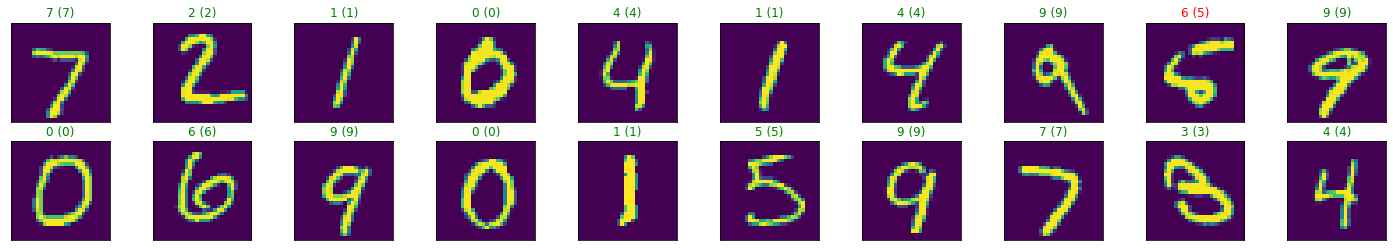

In [23]:
images,labels= next(iter(test_loader))
output= model(images)
_,pred= torch.max(output,1)

images=images.numpy()

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax= fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(images[idx]))
    ax.set_title("{} ({})".format(str(pred[idx].item()), str(labels[idx].item())),
                 color=("green" if pred[idx]==labels[idx] else "red"))